# c_beta Analysis

In [13]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import EpiClockInvasiveBRCA.src.util as epi_util
from EpiClockInvasiveBRCA.src.consts import consts

In [14]:
## Set up directories for figures

figure_outdir = 'figures'
clin_path_outdir = os.path.join(figure_outdir, 'clin_path')
cell_chars_outdir = os.path.join(figure_outdir, 'cell_chars')

if not os.path.exists(clin_path_outdir):
    os.makedirs(clin_path_outdir)
if not os.path.exists(cell_chars_outdir):
    os.makedirs(cell_chars_outdir)

## Prep data

In [15]:
## Data directories

TCGA_clinical_dir = os.path.join(consts['official_indir'], 'TCGA')
TCGA_c_beta_dir = os.path.join(consts['repo_dir'], 'Select_fCpGs', 'outputs')
Ringner_clinical_dir = os.path.join(consts['official_indir'], 'Ringner')
Ringner_c_beta_dir = os.path.join(consts['repo_dir'], 'Process_Other_Data_Sources', 'outputs', 'cohort_T2')

In [16]:
## Import clinical data for both cohorts into data dictionary
## Import c_beta values into dataframes

clinical = {}

# Lund

clinical['ringner'] = pd.read_table(os.path.join(Ringner_clinical_dir, 'cohort.T2.clinical.txt'), index_col=0, dtype={'grade':str})
clinical['ringner']['c_beta'] = pd.read_table(os.path.join(Ringner_c_beta_dir, 'cohort.T2.c_beta.txt'), index_col=0).squeeze("columns")

# TCGA

clinical['TCGA'] = pd.read_table(os.path.join(TCGA_clinical_dir, 'cohort1.clinical.tsv'), index_col=0)
clinical['TCGA'] = clinical['TCGA'].set_index('bcr_patient_barcode')
c_beta_tcga = pd.read_table(os.path.join(TCGA_c_beta_dir, 'cohort.T1.c_beta.txt'), index_col=0, header=None).squeeze("columns")
c_beta_tcga.index = c_beta_tcga.index.to_series().apply(epi_util.sampleToPatientID)
clinical['TCGA']['c_beta'] = c_beta_tcga

clinical['TCGA']['T Stage'] = clinical['TCGA']['ajcc_pathologic_t'].dropna().apply(lambda x:x[:2])
clinical['TCGA']['Stage'] = clinical['TCGA']['ajcc_pathologic_stage'].dropna().str.rstrip('ABC')
clinical['TCGA']['age'] = clinical['TCGA']['age_at_diagnosis'] / 365

# Add sample IDs (as opposed to patient/submitter IDs) to TCGA clinical table
patient_to_sample_IDs = pd.read_table(os.path.join(TCGA_clinical_dir, 'patient_to_sample_IDs.txt'), index_col=0).squeeze('columns')
clinical['TCGA'] = clinical['TCGA'].merge(patient_to_sample_IDs, left_index=True, right_index=True, how='left')

### Import subtyping results

In [5]:
## Import pam50 subtype predictions from log2 norm TPM
## Merge subtype column with TCGA clinical table

TCGA_genefu_pam50_subtypes_log2_norm = pd.read_table('../Subtyping/TCGA.genefu.pam50.subtypes_log2.norm.txt')
TCGA_genefu_pam50_subtypes_log2_norm.index = TCGA_genefu_pam50_subtypes_log2_norm['libName'].apply(lambda x:epi_util.sampleToPatientID(x.replace('.', '-')))
TCGA_genefu_pam50_subtypes_log2_norm = TCGA_genefu_pam50_subtypes_log2_norm.drop('libName', axis=1)
clinical['TCGA'] = clinical['TCGA'].merge(TCGA_genefu_pam50_subtypes_log2_norm['subtype.pam50'], left_index=True, right_index=True, how='left')

### RNA-seq

In [6]:
## Import RNA-seq TPM data

markers_TPM_df = pd.read_table(
    os.path.join(TCGA_clinical_dir, 'cohort1.rnaseq_tpm.tsv'),
    sep='\t')
markers_TPM_df = markers_TPM_df.set_index('gene_id')
markers_TPM_df = markers_TPM_df.rename(columns=lambda x:'-'.join(x.split('-')[:3]))
gene_name = markers_TPM_df.pop('gene_name')
nonzero_values = (markers_TPM_df != 0).any(axis=1)

markers_TPM_df = markers_TPM_df.loc[nonzero_values]
gene_name = gene_name.loc[nonzero_values]

In [7]:
## Log transform TPM and center the values for each gene across all tumors

markers_log_transformed_df = np.log2(markers_TPM_df + 1)
markers_transformed_df = markers_log_transformed_df.apply(lambda col:col - markers_log_transformed_df.mean(axis=1), axis=0)
assert (markers_transformed_df.mean(axis=1) < 1e-5).all()

In [8]:
## Gene modules

# Import gene modules from Fredlund et al.

gene_module_dict = {}
with open(os.path.join(consts['official_indir'], 'misc', 'Fredlund.gene.modules.txt'), 'r') as f:
    line_list = f.readlines()

for line in line_list:
    list_temp = line.rstrip().split('\t')
    gene_module_dict[list_temp[0]] = list_temp[1:]
    
# Add columns for the average expression of each gene module

for module in gene_module_dict.keys():
    markers = gene_module_dict[module]
    genes_used = gene_name.index[gene_name.isin(markers)]
    if genes_used.shape[0] != len(markers):
        print(f'{len(markers) - genes_used.shape[0]} genes not found from the {module} module')
    selected_TPM = markers_transformed_df.loc[genes_used]
    avg_module_expression = selected_TPM.mean(axis=0)
    avg_module_expression.name = module
    clinical['TCGA'] = clinical['TCGA'].drop(module, axis=1, errors='ignore')
    clinical['TCGA'] = clinical['TCGA'].merge(avg_module_expression, left_index=True, right_index=True, how='left')

1 genes not found from the IR module


In [9]:
## Include expression of certain genes in clinical table
## Genes specifically relevant for breast cancer

clinical['TCGA']['MKI67'] = markers_transformed_df.loc[gene_name.index[gene_name=='MKI67']].T

MCM_family = ['MCM2', 'MCM3', 'MCM4', 'MCM5', 'MCM6', 'MCM7']
clinical['TCGA']['MCM'] = markers_transformed_df.loc[gene_name.index[gene_name.isin(MCM_family)]].mean(axis=0)

### Copy number analysis

In [10]:
## Import CNV table and transform data

CNV_df = pd.read_table(
    os.path.join(TCGA_clinical_dir, 'cohort1.cnv.tsv'),
    sep='\t')
CNV_df['CN'] = 2 * (2 ** CNV_df['Segment_Mean'])
all_samples = CNV_df['Sample'].unique()

In [11]:
## Iterate through samples and calculate CN losses and gains

# Thresholds for CN losses and gains
FGA_loss_threshold = 1.5
FGA_gain_threshold = 2.5

# Store FGA loss/gain and ploidy (not used) for each sample
FGA_loss_list = []
FGA_gain_list = []
ploidy_list = []

for samp in all_samples:

    # Select only rows corresponding to this sample
    sample_CNV_df = CNV_df.loc[CNV_df['Sample'] == samp]
    
    total_num_probes = sample_CNV_df['Num_Probes'].sum()
    
    # Sum of number of probes in regions that are beyond the loss and gain thresholds
    FGA_loss = sample_CNV_df.loc[sample_CNV_df['CN'] < FGA_loss_threshold, 'Num_Probes'].sum() / total_num_probes
    FGA_gain = sample_CNV_df.loc[sample_CNV_df['CN'] > FGA_gain_threshold, 'Num_Probes'].sum() / total_num_probes

    FGA_loss_list.append(FGA_loss)
    FGA_gain_list.append(FGA_gain)

    ploidy_list.append(
        (sample_CNV_df['CN'] * sample_CNV_df['Num_Probes']).sum() / total_num_probes
    )
    
FGA_output = pd.DataFrame(index=all_samples, data={'FGA_loss':FGA_loss_list, 'FGA_gain':FGA_gain_list})
FGA_output['FGA'] = FGA_output['FGA_loss'] + FGA_output['FGA_gain']
FGA_output.index = FGA_output.index.to_series().apply(lambda x:'-'.join(x.split('-')[:3]))

# Add new columns to TCGA clinical table
clinical['TCGA'] = clinical['TCGA'].drop(['FGA_loss', 'FGA_gain', 'FGA'], axis=1, errors='ignore')
clinical['TCGA'] = clinical['TCGA'].merge(FGA_output, left_index=True, right_index=True, how='left')

### Save annotated clinical file for TCGA cohort

In [12]:
# Save modified TCGA clinical table

clinical_annotated_filepath = os.path.join(TCGA_clinical_dir, 'cohort1.clinical.annotated.tsv')
if os.path.exists(clinical_annotated_filepath):
    existing_table = pd.read_table(clinical_annotated_filepath, index_col=0)
    assert (existing_table.round(5).fillna(0) == clinical['TCGA'].round(5).fillna(0)).all(axis=None, skipna=True)
else:
    clinical['TCGA'].to_csv(clinical_annotated_filepath, sep='\t')

## Make Figures

In [17]:
# scale factor
sf = 0.4

figsize = np.array([7, 6])
labelfontsize = 25
ticksfontsize = 18
signif_fontsize = 14
opacity = 0.8
linewidth = 1
fliersize = 1

sns.set(rc={"savefig.bbox":'tight', 'axes.linewidth':sf}, font_scale=1, style='ticks')

In [18]:
# Must set dataframe names for use of saveBoxPlotNew and saveCorrelationPlot

clinical['TCGA'].name = 'TCGA'
clinical['ringner'].name = 'Lund'

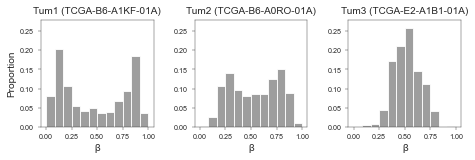

In [20]:
data = {'tumor':{'beta_values_balancedSites':
        pd.read_table(os.path.join(TCGA_clinical_dir, 'cohort1.methyl.balancedSites.tsv'),
                      index_col=0)
       }}

sample_list = {'Tum1':'TCGA-B6-A1KF-01A',
               'Tum2':'TCGA-B6-A0RO-01A',
               'Tum3':'TCGA-E2-A1B1-01A'
              }

# epi_util.plotTumorWise(data, CpG_list=balanced_CpGs_final_set, sample_list=[sample_list[tum] for tum in sample_list],
epi_util.plotTumorWise(data, data_obj='beta_values_balancedSites', sample_list=[sample_list[tum] for tum in sample_list],
                     suptitle='', xlabel='β', title_formats=[tum + ' ({})' for tum in sample_list],
                     outfile=True, outdir=figure_outdir, outfile_name='example_tumors.pdf',
                     choose_random=False, color=consts['palette_jco'][2],
                     ylim=(0, 0.28), bins=12,
                     figsize=figsize * [2.3, 0.8], text_fontsize=labelfontsize, ticksfontsize=ticksfontsize, opacity=opacity, sf=sf,
                     tight_layout_pad=0.2
             )

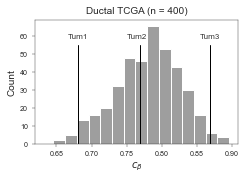

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize * [1.3, 0.95] * sf)

plot_data = clinical['TCGA'].loc[clinical['TCGA']['in_analysis_dataset'], 'c_beta']
sns.histplot(ax=ax, x=plot_data,
             color=consts['palette_jco'][2], alpha=opacity)

x_0 = clinical['TCGA'].loc[epi_util.sampleToPatientID(sample_list['Tum1']), 'c_beta']
x_1 = clinical['TCGA'].loc[epi_util.sampleToPatientID(sample_list['Tum2']), 'c_beta']
x_2 = clinical['TCGA'].loc[epi_util.sampleToPatientID(sample_list['Tum3']), 'c_beta']

line_color = 'black'

tumor_heights = [0.8, 0.8, 0.8]
ax.axvline(x=x_0, ymax=tumor_heights[0], lw=2.5 * sf, color=line_color)
ax.axvline(x=x_1, ymax=tumor_heights[1], lw=2.5 * sf, color=line_color)
ax.axvline(x=x_2, ymax=tumor_heights[2], lw=2.5 * sf, color=line_color)

ax.set_xlabel('$c_β$', fontsize=labelfontsize * sf)
ax.set_ylabel('Count', fontsize=labelfontsize * sf)
ax.set_title(f"Ductal TCGA (n = {(~plot_data.isna()).sum()})", fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

xlim = ax.get_xlim()
width = xlim[1] - xlim[0]
ax.set_xlim(left = xlim[0] - width/20)
y_height = ax.get_ylim()[1]

ax.text(x_0, (tumor_heights[0]+0.05)*y_height,
        'Tum1', color=line_color,
        ha="center", fontfamily='sans-serif', fontsize=0.8 * labelfontsize * sf, alpha=opacity
       )
ax.text(x_1-0.005, (tumor_heights[1]+0.05)*y_height,
        'Tum2', color=line_color,
        ha="center", fontfamily='sans-serif', fontsize=0.8 * labelfontsize * sf, alpha=opacity
       )
ax.text(x_2, (tumor_heights[2]+0.05)*y_height,
        'Tum3', color=line_color,
        ha="center", fontfamily='sans-serif', fontsize=0.8 * labelfontsize * sf, alpha=opacity
       )

fig.savefig(os.path.join(figure_outdir, 'c_beta_distribution.pdf'), format='pdf', pad_inches=0.1)

Median c_beta of ductal TCGA tumors: 0.785
Median c_beta of lobular TCGA tumors: 0.819
Wilcoxon rank sum test: P = 2e-16


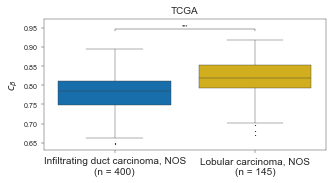

In [12]:
major_diagnoses = ['Infiltrating duct carcinoma, NOS', 'Lobular carcinoma, NOS']
epi_util.saveBoxPlotNew(clinical['TCGA'], 'primary_diagnosis', restrict=False,
                   var_y='c_beta',
                   outdir=clin_path_outdir, title=True, use_groups=major_diagnoses,
                   palette=consts['palette_jco'], signif_fontsize=signif_fontsize,
                   figsize=figsize * [1.8, 1], labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, linewidth=linewidth, fliersize=fliersize)

clinical['TCGA'].groupby('primary_diagnosis')['c_beta'].median()[major_diagnoses]
ductal_c_betas = clinical['TCGA'].loc[clinical['TCGA']['primary_diagnosis'] == 'Infiltrating duct carcinoma, NOS', 'c_beta'].dropna()
lobular_c_betas = clinical['TCGA'].loc[clinical['TCGA']['primary_diagnosis'] == 'Lobular carcinoma, NOS', 'c_beta'].dropna()
pvalue = epi_util.wilcoxonRankSums(ductal_c_betas, lobular_c_betas).pvalue

print(f'Median c_beta of ductal TCGA tumors: {np.median(ductal_c_betas):.3f}')
print(f'Median c_beta of lobular TCGA tumors: {np.median(lobular_c_betas):.3f}')
print(f'Wilcoxon rank sum test: P = {pvalue:.0e}')

<Axes: title={'center': 'Lund'}, ylabel='$c_β$'>

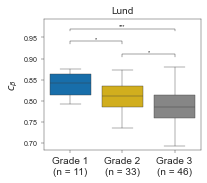

In [39]:
epi_util.saveBoxPlotNew(clinical['ringner'], 'grade', restrict=True,
                   var_y='c_beta',
                   outdir=clin_path_outdir, title=True, use_groups=['Grade 1', 'Grade 2', 'Grade 3'],
                   palette=consts['palette_jco'],
                   figsize=figsize, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, linewidth=linewidth, fliersize=fliersize)

<Axes: title={'center': 'TCGA'}, ylabel='$c_β$'>

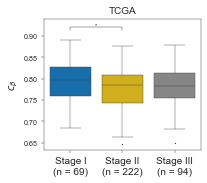

In [40]:
epi_util.saveBoxPlotNew(clinical['TCGA'], 'Stage', restrict=True,
                   var_y='c_beta',
                   outdir=clin_path_outdir, title=True, use_groups = ['Stage I', 'Stage II', 'Stage III'],
                   palette=consts['palette_jco'],
                   figsize=figsize, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, linewidth=linewidth, fliersize=fliersize)

<Axes: title={'center': 'Lund'}, ylabel='$c_β$'>

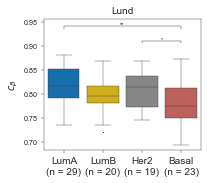

In [41]:
epi_util.saveBoxPlotNew(clinical['ringner'], 'genefu.pam50.subtype', restrict=True,
                   var_y='c_beta',
                   outdir=clin_path_outdir, title=True, use_groups = ['LumA', 'LumB', 'Her2', 'Basal'],
                   palette=consts['palette_jco'],
                   figsize=figsize, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, linewidth=linewidth, fliersize=fliersize)

<Axes: title={'center': 'TCGA'}, ylabel='$c_β$'>

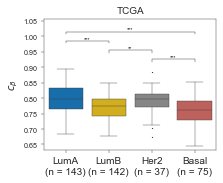

In [58]:
epi_util.saveBoxPlotNew(clinical['TCGA'], 'subtype.pam50', restrict=True,
                   var_y='c_beta',
                   outdir=clin_path_outdir, title=True, use_groups = ['LumA', 'LumB', 'Her2', 'Basal'],
                   palette=consts['palette_jco'], plot_ymax_mult=0.2,
                   figsize=figsize * [1.1, 1], labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, linewidth=linewidth, fliersize=fliersize)

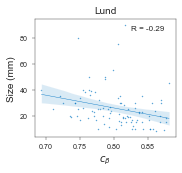

In [43]:
epi_util.saveCorrelationPlot(clinical['ringner'], var_y='size', restrict=True,
                           var_x='c_beta',
                           outdir=clin_path_outdir, label='Size (mm)',
                           text_x=0.85, text_y=85,
                           figsize=figsize * 0.9, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

<Axes: title={'center': 'TCGA'}, ylabel='$c_β$'>

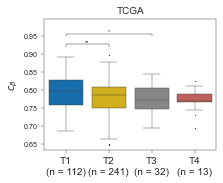

In [59]:
epi_util.saveBoxPlotNew(clinical['TCGA'], 'T Stage', restrict=True,
                   var_y='c_beta',
                   outdir=clin_path_outdir, title=True, use_groups = ['T1', 'T2', 'T3', 'T4'],
                   palette=consts['palette_jco'],
                   figsize=figsize * [1.1, 1], labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, linewidth=linewidth, fliersize=fliersize)

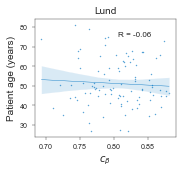

In [45]:
epi_util.saveCorrelationPlot(clinical['ringner'], var_y='age', restrict=True,
                           var_x='c_beta',
                           outdir=clin_path_outdir, label='Patient age (years)',
                           text_x=0.83, text_y=75,
                           figsize=figsize * 0.9, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

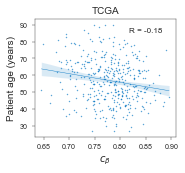

In [46]:
epi_util.saveCorrelationPlot(clinical['TCGA'], var_y='age', restrict=True,
                           var_x='c_beta',
                           outdir=clin_path_outdir, label='Patient age (years)',
                           text_x=0.85, text_y=85,
                           figsize=figsize * 0.9, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

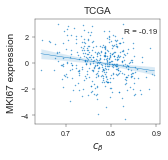

In [47]:
epi_util.saveCorrelationPlot(clinical['TCGA'], var_y='MKI67', restrict=True,
                           var_x='c_beta',
                           outdir=cell_chars_outdir,
                           text_x=0.865, text_y=2.2, label='MKI67 expression',
                           figsize=figsize * 0.8, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

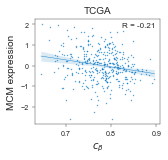

In [48]:
epi_util.saveCorrelationPlot(clinical['TCGA'], var_y='MCM', restrict=True,
                           var_x='c_beta',
                           outdir=cell_chars_outdir,
                           text_x=0.86, text_y=1.8, label='MCM expression',
                           figsize=figsize * 0.8, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

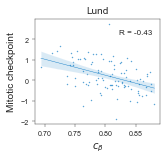

In [49]:
epi_util.saveCorrelationPlot(clinical['ringner'], var_y='Mitotic Checkpoint', restrict=True,
                           var_x='c_beta',
                           outdir=cell_chars_outdir,
                           text_x=0.85, text_y=2.2,
                           figsize=figsize * 0.8, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )


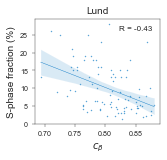

In [50]:
epi_util.saveCorrelationPlot(clinical['ringner'], var_y='spfPercent', restrict=True,
                           var_x='c_beta',
                           label='S-phase fraction (%)',
                           outdir=cell_chars_outdir,
                           text_x=0.85, text_y=26,
                           figsize=figsize * 0.8, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

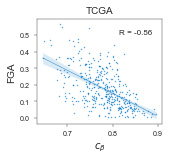

In [51]:
epi_util.saveCorrelationPlot(clinical['TCGA'], var_y='FGA', restrict=True,
                           var_x='c_beta',
                           outdir=cell_chars_outdir, label='FGA',
                           text_x=0.85, text_y=0.5,
                           figsize=figsize * 0.8, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

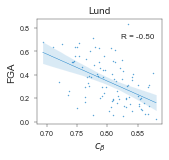

In [52]:
epi_util.saveCorrelationPlot(clinical['ringner'], var_y='FGA', restrict=True,
                           var_x='c_beta',
                           outdir=cell_chars_outdir, label='FGA',
                           text_x=0.85, text_y=0.7,
                           figsize=figsize * 0.8, labelfontsize=labelfontsize, ticksfontsize=ticksfontsize, sf=sf, s=1,
                           color=consts['palette_jco'][0], line_kws={'linewidth':1 * sf}
                          )

In [53]:
gene_list = markers_transformed_df.index.values # list of genes to search
use_samples = clinical['TCGA'].index[clinical['TCGA']['in_analysis_dataset']] # list of samples to use - make sure these are only pure ductal samples

c_beta_use_samples = clinical['TCGA'].loc[use_samples, 'c_beta']
markers_transformed_df_use_samples = markers_transformed_df[use_samples]

rvalue_list = []
for i in range(len(gene_list)):
    if i % 5000 == 0:
        print(i)
    
    res = epi_util.pearsonCorrelation(c_beta_use_samples, markers_transformed_df_use_samples.loc[gene_list[i]])
    rvalue_list.append(res.rvalue)

rvalue_ser = pd.Series(index=gene_list, data=rvalue_list)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000


19259 protein coding genes considered


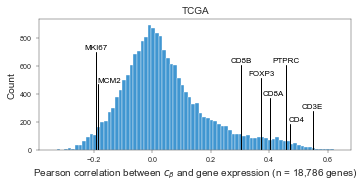

In [110]:
genenames_proteincoding = pd.read_table(os.path.join(consts['official_indir'], 'misc', 'genenames.proteincoding.txt'),
                                       low_memory=False, usecols=['symbol']).squeeze('columns').values

print(f'{genenames_proteincoding.shape[0]} protein coding genes considered')

fig, ax = plt.subplots(1, 1, figsize=figsize * [2, 1] * sf)

plot_data = rvalue_ser[gene_name.isin(genenames_proteincoding)]
sns.histplot(ax=ax, x=plot_data,
             color=consts['palette_jco'][0])

genes_displayed = ['MKI67', 'MCM2', 'CD3E', 'CD4', 'CD8A', 'CD8B', 'FOXP3', 'PTPRC']
heights = [0.85, 0.6, 0.5, 0.25, 0.75, 0.75, 0.75, 0.75]

gene_heights = {
    'MKI67': 0.75,
    'MCM2': 0.5,
    'CD3E': 0.3,
    'CD4': 0.2,
    'CD8A': 0.4,
    'CD8B': 0.65,
    'FOXP3': 0.55,
    'PTPRC': 0.65
}
horiz_offset = {
    'MCM2':0.04,
    'CD8A':0.01,
    'CD4':0.02
}
y_height = ax.get_ylim()[1]
for gene in gene_heights:
    corr = rvalue_ser.loc[gene_name.index[gene_name == gene]].values
    assert len(corr) == 1
    x_pos = corr[0]
    if gene in horiz_offset:
        x_pos += horiz_offset[gene]
    ax.axvline(x=corr[0], ymin=0, ymax=gene_heights[gene], color='black', lw=2.5 * sf)
    ax.text(x_pos, (gene_heights[gene] + 0.02)*y_height, gene,
                            ha="center", fontfamily='sans-serif', fontsize=labelfontsize * 0.8 * sf, color='black'
           )

ax.set_ylabel('Count', fontsize=labelfontsize * sf)
ax.set_xlabel(f'Pearson correlation between $c_β$ and gene expression (n = {len(plot_data):,} genes)', fontsize=labelfontsize * sf)
ax.set_title(f'TCGA', fontsize=labelfontsize * sf)
ax.tick_params(axis='both', labelsize=ticksfontsize * sf, width=sf, length=8 * sf)

fig.savefig(os.path.join(cell_chars_outdir, 'all_gene_correlations.pdf'), format='pdf', pad_inches=0.1)